# Synthetic Dataset & Scalability
C. Heiser, 2019

---
__The purpose of this notebook is to evaluate our structural preservation metrics on a synthetic dataset of known high-dimensional structure and determine their scalability to datasets with a large number of observations.__  

As a reminder, unique pairwise distances in a dataset with _n_ cells is calculated as:  
$$D=(n*(n-1))/2$$  
  
To benchmark these techniques, we are using a **"Swiss Roll"** dataset built using `sklearn.datasets.make_swiss_roll()`.

In [1]:
import sys
sys.path.append('../')
from fcc_utils import *

In [ ]:
# reload functions when editing file
del sys.modules['fcc_utils']
from fcc_utils import *

In [2]:
from sklearn import datasets # for swiss roll dataset
import mpl_toolkits.mplot3d.axes3d as p3 # 3D plotting

---
### 1K-Point Swiss Roll

In [ ]:
X, t = datasets.make_swiss_roll(n_samples=1000, noise=0.0, random_state=18)

In [ ]:
fig = plt.figure()
ax = p3.Axes3D(fig)
ax.view_init(12, -80)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], color=plt.cm.jet(t), s=20, edgecolor='k')

In [ ]:
swiss_1k = sc.AnnData(X=X) # initialize AnnData
swiss_1k.obs['pos'] = t # add univariate position according to main dim of manifold to .obs

swiss_1k

In [ ]:
# 'top down' view
DR_plot().plot(swiss_1k.X, color=swiss_1k.obs['pos'])

In [ ]:
# 'front' view
DR_plot().plot(swiss_1k.X[:,[0,2]], color=swiss_1k.obs['pos'])

In [ ]:
# perform PCA
sc.tl.pca(swiss_1k, n_comps=2)

In [ ]:
# create neighborhood graphs from PCA results for UMAP and Louvain clustering
# heads-up: you will get a numba deprecation warning the first time you run this
sc.pp.neighbors(swiss_1k, n_neighbors=30, use_rep='X', knn=True, random_state=18, metric='euclidean', copy=False)

In [ ]:
# perform Louvain clustering
sc.tl.louvain(swiss_1k, resolution=0.5, key_added='louvain', random_state=18, copy=False)
# put cluster names in string column of .obs for plotting
swiss_1k.obs['clusterID'] = 'cluster_' + swiss_1k.obs['louvain'].astype(str)

In [ ]:
DR_plot(dim_name='PC').plot(swiss_1k.obsm['X_pca'], color=swiss_1k.obs['pos'])

In [ ]:
DR_plot(dim_name='PC').plot_IDs(swiss_1k, use_rep='X_pca', obs_col='clusterID')

In [ ]:
# perform UMAP
sc.tl.umap(swiss_1k, random_state=18)

In [ ]:
DR_plot(dim_name='UMAP').plot(swiss_1k.obsm['X_umap'], color=swiss_1k.obs['pos'])

In [ ]:
DR_plot(dim_name='UMAP').plot_IDs(swiss_1k, use_rep='X_umap', obs_col='clusterID')

In [ ]:
# perform t-SNE
sc.tl.tsne(swiss_1k, use_rep='X', perplexity=30, random_state=18)

In [ ]:
DR_plot(dim_name='t-SNE').plot(swiss_1k.obsm['X_tsne'], color=swiss_1k.obs['pos'])

In [ ]:
DR_plot(dim_name='t-SNE').plot_IDs(swiss_1k, use_rep='X_tsne', obs_col='clusterID')

In [ ]:
# create dictionaries for dumping results into
final_distance_stats = {1000:{'R':{}, 'EMD':{}, 'Knn Pres.':{}, 'Time':{}}, 10000:{'R':{}, 'EMD':{}, 'Knn Pres.':{}, 'Time':{}}, 100000:{'R':{}, 'EMD':{}, 'Knn Pres.':{}, 'Time':{}}}

In [ ]:
%%time
# save distance matrices in AnnData object for easy access
swiss_1k.uns['tsne_distance'] = pdist(swiss_1k.obsm['X_tsne'])
swiss_1k.uns['umap_distance'] = pdist(swiss_1k.obsm['X_umap'])
swiss_1k.uns['pca_distance'] = pdist(swiss_1k.obsm['X_pca'])
swiss_1k.uns['native_distance'] = pdist(swiss_1k.X)

In [ ]:
%%time
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=swiss_1k.uns['native_distance'], post=swiss_1k.uns['pca_distance'])
print('R: {}\nEMD: {}'.format(round(mantel_stats[0],4), round(EMD,4)))
plt.figure(figsize=(4,4))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
# dump o/p into dictionary
final_distance_stats[1000]['R']['PCA (2)'], final_distance_stats[1000]['EMD']['PCA (2)'] = mantel_stats[0], EMD

In [ ]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=swiss_1k.uns['native_distance'], post=swiss_1k.uns['tsne_distance'])
print('R: {}\nEMD: {}'.format(round(mantel_stats[0],4), round(EMD,4)))
plt.figure(figsize=(4,4))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
# dump o/p into dictionary
final_distance_stats[1000]['R']['t-SNE'], final_distance_stats[1000]['EMD']['t-SNE'] = mantel_stats[0], EMD

In [ ]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=swiss_1k.uns['native_distance'], post=swiss_1k.uns['umap_distance'])
print('R: {}\nEMD: {}'.format(round(mantel_stats[0],4), round(EMD,4)))
plt.figure(figsize=(4,4))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
# dump o/p into dictionary
final_distance_stats[1000]['R']['UMAP'], final_distance_stats[1000]['EMD']['UMAP'] = mantel_stats[0], EMD

---
### 10K-Point Swiss Roll

In [ ]:
X, t = datasets.make_swiss_roll(n_samples=10000, noise=0.0, random_state=18)

In [ ]:
fig = plt.figure()
ax = p3.Axes3D(fig)
ax.view_init(12, -80)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], color=plt.cm.jet(t), s=20, edgecolor='k')

In [ ]:
swiss_10k = sc.AnnData(X=X) # initialize AnnData
swiss_10k.obs['pos'] = t # add univariate position according to main dim of manifold to .obs

swiss_10k

In [ ]:
# perform PCA
sc.tl.pca(swiss_10k, n_comps=2)

In [ ]:
# create neighborhood graphs from PCA results for UMAP and Louvain clustering
# heads-up: you will get a numba deprecation warning the first time you run this
sc.pp.neighbors(swiss_10k, n_neighbors=100, use_rep='X', knn=True, random_state=18, metric='euclidean', copy=False)

In [ ]:
# perform Louvain clustering
sc.tl.louvain(swiss_10k, resolution=0.5, key_added='louvain', random_state=18, copy=False)
# put cluster names in string column of .obs for plotting
swiss_10k.obs['clusterID'] = 'cluster_' + swiss_10k.obs['louvain'].astype(str)

In [ ]:
DR_plot(dim_name='PC').plot(swiss_10k.obsm['X_pca'], color=swiss_10k.obs['pos'])

In [ ]:
DR_plot(dim_name='PC').plot_IDs(swiss_10k, use_rep='X_pca', obs_col='clusterID')

In [ ]:
# perform UMAP
%time sc.tl.umap(swiss_10k, random_state=18)

In [ ]:
DR_plot(dim_name='UMAP').plot(swiss_10k.obsm['X_umap'], color=swiss_10k.obs['pos'])

In [ ]:
DR_plot(dim_name='UMAP').plot_IDs(swiss_10k, use_rep='X_umap', obs_col='clusterID')

In [ ]:
# perform t-SNE
%time sc.tl.tsne(swiss_10k, use_rep='X', perplexity=100, random_state=18)

In [ ]:
DR_plot(dim_name='t-SNE').plot(swiss_10k.obsm['X_tsne'], color=swiss_10k.obs['pos'])

In [ ]:
DR_plot(dim_name='t-SNE').plot_IDs(swiss_10k, use_rep='X_tsne', obs_col='clusterID')

In [ ]:
%%time
# save distance matrices in AnnData object for easy access
swiss_10k.uns['tsne_distance'] = pdist(swiss_10k.obsm['X_tsne'])
swiss_10k.uns['umap_distance'] = pdist(swiss_10k.obsm['X_umap'])
swiss_10k.uns['pca_distance'] = pdist(swiss_10k.obsm['X_pca'])
swiss_10k.uns['native_distance'] = pdist(swiss_10k.X)

In [ ]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=swiss_10k.uns['native_distance'], post=swiss_10k.uns['pca_distance'])
print('R: {}\nEMD: {}'.format(round(mantel_stats[0],4), round(EMD,4)))
plt.figure(figsize=(4,4))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
# dump o/p into dictionary
final_distance_stats[10000]['R']['PCA (2)'], final_distance_stats[10000]['EMD']['PCA (2)'] = mantel_stats[0], EMD

In [ ]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=swiss_10k.uns['native_distance'], post=swiss_10k.uns['tsne_distance'])
print('R: {}\nEMD: {}'.format(round(mantel_stats[0],4), round(EMD,4)))
plt.figure(figsize=(4,4))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
# dump o/p into dictionary
final_distance_stats[10000]['R']['t-SNE'], final_distance_stats[10000]['EMD']['t-SNE'] = mantel_stats[0], EMD

In [ ]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=swiss_10k.uns['native_distance'], post=swiss_10k.uns['umap_distance'])
print('R: {}\nEMD: {}'.format(round(mantel_stats[0],4), round(EMD,4)))
plt.figure(figsize=(4,4))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
# dump o/p into dictionary
final_distance_stats[10000]['R']['UMAP'], final_distance_stats[10000]['EMD']['UMAP'] = mantel_stats[0], EMD

---
### 20K-Point Swiss Roll

In [ ]:
X, t = datasets.make_swiss_roll(n_samples=20000, noise=0.0, random_state=18)

In [ ]:
fig = plt.figure()
ax = p3.Axes3D(fig)
ax.view_init(12, -80)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], color=plt.cm.jet(t), s=20, edgecolor='k')

In [ ]:
swiss_20k = sc.AnnData(X=X) # initialize AnnData
swiss_20k.obs['pos'] = t # add univariate position according to main dim of manifold to .obs

swiss_20k

In [ ]:
# perform PCA
%time sc.tl.pca(swiss_20k, n_comps=2)

In [ ]:
# create neighborhood graphs from PCA results for UMAP and Louvain clustering
# heads-up: you will get a numba deprecation warning the first time you run this
sc.pp.neighbors(swiss_20k, n_neighbors=150, use_rep='X', knn=True, random_state=18, metric='euclidean', copy=False)

In [ ]:
%%time
# perform Louvain clustering
sc.tl.louvain(swiss_20k, resolution=0.5, key_added='louvain', random_state=18, copy=False)
# put cluster names in string column of .obs for plotting
swiss_20k.obs['clusterID'] = 'cluster_' + swiss_20k.obs['louvain'].astype(str)

In [ ]:
DR_plot(dim_name='PC').plot(swiss_20k.obsm['X_pca'], color=swiss_20k.obs['pos'])

In [ ]:
DR_plot(dim_name='PC').plot_IDs(adata=swiss_20k, use_rep='X_pca', obs_col='clusterID')

In [ ]:
# perform UMAP
%time sc.tl.umap(swiss_20k, random_state=18)

In [ ]:
DR_plot(dim_name='UMAP').plot(swiss_20k.obsm['X_umap'], color=swiss_20k.obs['pos'])

In [ ]:
DR_plot(dim_name='UMAP').plot_IDs(adata=swiss_20k, use_rep='X_umap', obs_col='clusterID')

In [ ]:
# perform t-SNE
%time sc.tl.tsne(swiss_20k, use_rep='X', perplexity=150, random_state=18)

In [ ]:
DR_plot(dim_name='t-SNE').plot(swiss_20k.obsm['X_tsne'], color=swiss_20k.obs['pos'])

In [ ]:
DR_plot(dim_name='t-SNE').plot_IDs(adata=swiss_20k, use_rep='X_tsne', obs_col='clusterID')

In [ ]:
%%time
# save distance matrices in AnnData object for easy access
swiss_20k.uns['tsne_distance'] = pdist(swiss_20k.obsm['X_tsne'])
swiss_20k.uns['umap_distance'] = pdist(swiss_20k.obsm['X_umap'])
swiss_20k.uns['pca_distance'] = pdist(swiss_20k.obsm['X_pca'])
swiss_20k.uns['native_distance'] = pdist(swiss_20k.X)

In [ ]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=swiss_20k.uns['native_distance'], post=swiss_20k.uns['pca_distance'])
print('R: {}\nEMD: {}'.format(round(mantel_stats[0],4), round(EMD,4)))
plt.figure(figsize=(4,4))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
# dump o/p into dictionary
#final_distance_stats[20000]['R']['PCA (2)'], final_distance_stats[20000]['EMD']['PCA (2)'] = mantel_stats[0], EMD

In [ ]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=swiss_20k.uns['native_distance'], post=swiss_20k.uns['tsne_distance'])
print('R: {}\nEMD: {}'.format(round(mantel_stats[0],4), round(EMD,4)))
plt.figure(figsize=(4,4))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
# dump o/p into dictionary
#final_distance_stats[20000]['R']['t-SNE'], final_distance_stats[20000]['EMD']['t-SNE'] = mantel_stats[0], EMD

In [ ]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=swiss_20k.uns['native_distance'], post=swiss_20k.uns['umap_distance'])
print('R: {}\nEMD: {}'.format(round(mantel_stats[0],4), round(EMD,4)))
plt.figure(figsize=(4,4))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
# dump o/p into dictionary
#final_distance_stats[20000]['R']['UMAP'], final_distance_stats[20000]['EMD']['UMAP'] = mantel_stats[0], EMD

---
### 50K-Point Swiss Roll

In [3]:
X, t = datasets.make_swiss_roll(n_samples=50000, noise=0.0, random_state=18)

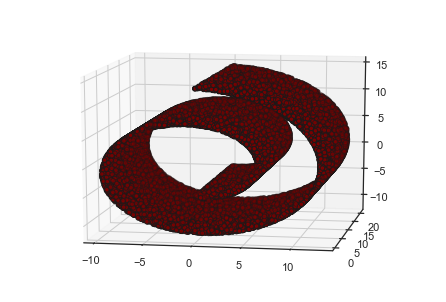

In [4]:
fig = plt.figure()
ax = p3.Axes3D(fig)
ax.view_init(12, -80)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], color=plt.cm.jet(t), s=20, edgecolor='k')

In [5]:
swiss_50k = sc.AnnData(X=X) # initialize AnnData
swiss_50k.obs['pos'] = t # add univariate position according to main dim of manifold to .obs

swiss_50k

AnnData object with n_obs × n_vars = 50000 × 3 
    obs: 'pos'

In [6]:
# perform PCA
%time sc.tl.pca(swiss_50k, n_comps=2)

CPU times: user 40.8 ms, sys: 57.9 ms, total: 98.6 ms
Wall time: 12.4 ms


In [7]:
# create neighborhood graphs from PCA results for UMAP and Louvain clustering
# heads-up: you will get a numba deprecation warning the first time you run this
%time sc.pp.neighbors(swiss_50k, n_neighbors=225, use_rep='X', knn=True, random_state=18, metric='euclidean', copy=False)

/Users/cody/.virtualenvs/lau_lab/lib/python3.7/site-packages/umap/rp_tree.py:450: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "make_euclidean_tree" failed type inference due to: Cannot unify RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none) and RandomProjectionTreeNode(none, bool, array(float32, 1d, C), float64, RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none), RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none)) for '$14.16', defined at /Users/cody/.virtualenvs/lau_lab/lib/python3.7/site-packages/umap/rp_tree.py (457)

File "../../../.virtualenvs/lau_lab/lib/python3.7/site-packages/umap/rp_tree.py", line 457:
def make_euclidean_tree(data, indices, rng_state, leaf_size=30):
    <source elided>

        left_node = make_euclidean_tree(data, left_indices, rng_state, leaf_size)
        ^

[1] During: resolving callee type: recursive(type(CPUDispatcher(<funct

CPU times: user 1min 7s, sys: 1.11 s, total: 1min 8s
Wall time: 1min 7s


In [8]:
%%time
# perform Louvain clustering
sc.tl.louvain(swiss_50k, resolution=0.5, key_added='louvain', random_state=18, copy=False)
# put cluster names in string column of .obs for plotting
swiss_50k.obs['clusterID'] = 'cluster_' + swiss_50k.obs['louvain'].astype(str)

CPU times: user 1min 25s, sys: 879 ms, total: 1min 26s
Wall time: 1min 26s


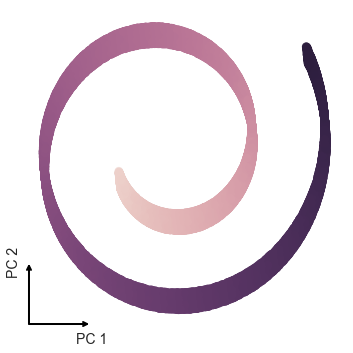

In [9]:
DR_plot(dim_name='PC').plot(swiss_50k.obsm['X_pca'], color=swiss_50k.obs['pos'])

In [10]:
# perform UMAP
%time sc.tl.umap(swiss_50k, random_state=18)

CPU times: user 1min 45s, sys: 3.93 s, total: 1min 49s
Wall time: 1min 2s


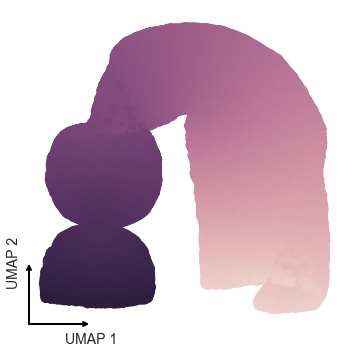

In [11]:
DR_plot(dim_name='UMAP').plot(swiss_50k.obsm['X_umap'], color=swiss_50k.obs['pos'])

In [12]:
# perform t-SNE
%time sc.tl.tsne(swiss_50k, use_rep='X', perplexity=225, random_state=18)

CPU times: user 11min 23s, sys: 7.65 s, total: 11min 31s
Wall time: 11min 31s


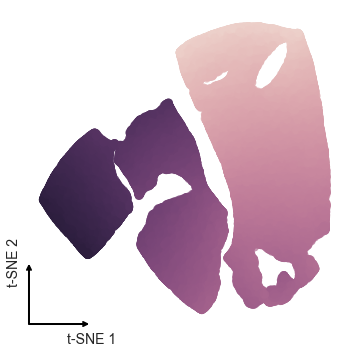

In [13]:
DR_plot(dim_name='t-SNE').plot(swiss_50k.obsm['X_tsne'], color=swiss_50k.obs['pos'])

In [18]:
%%time
# save distance matrices in AnnData object for easy access
swiss_50k.uns['tsne_distance'] = pdist(swiss_50k.obsm['X_tsne'])
swiss_50k.uns['umap_distance'] = pdist(swiss_50k.obsm['X_umap'])
swiss_50k.uns['pca_distance'] = pdist(swiss_50k.obsm['X_pca'])
swiss_50k.uns['native_distance'] = pdist(swiss_50k.X)

CPU times: user 18.4 s, sys: 11.1 s, total: 29.5 s
Wall time: 33.7 s


In [19]:
%time corr_stats = pearsonr(x=swiss_50k.uns['native_distance'], y=swiss_50k.uns['pca_distance'])

CPU times: user 28.7 s, sys: 47.1 s, total: 1min 15s
Wall time: 1min 29s


In [20]:
%%time
pre = swiss_50k.uns['native_distance'].copy()
post = swiss_50k.uns['pca_distance'].copy()

pre -= pre.min()
pre /= pre.ptp()
post -= post.min()
post /= post.ptp()

CPU times: user 13.2 s, sys: 10.9 s, total: 24.1 s
Wall time: 24.9 s


In [ ]:
%time EMD = wasserstein_1d(pre, post)

In [ ]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=swiss_50k.uns['native_distance'], post=swiss_50k.uns['pca_distance'])
print('R: {}\nEMD: {}'.format(round(mantel_stats[0],4), round(EMD,4)))
plt.figure(figsize=(4,4))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
# dump o/p into dictionary
#final_distance_stats[50000]['R']['PCA (2)'], final_distance_stats[50000]['EMD']['PCA (2)'] = mantel_stats[0], EMD

In [ ]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=swiss_50k.uns['native_distance'], post=swiss_50k.uns['tsne_distance'])
print('R: {}\nEMD: {}'.format(round(mantel_stats[0],4), round(EMD,4)))
plt.figure(figsize=(4,4))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
# dump o/p into dictionary
#final_distance_stats[50000]['R']['t-SNE'], final_distance_stats[50000]['EMD']['t-SNE'] = mantel_stats[0], EMD

In [ ]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=swiss_50k.uns['native_distance'], post=swiss_50k.uns['umap_distance'])
print('R: {}\nEMD: {}'.format(round(mantel_stats[0],4), round(EMD,4)))
plt.figure(figsize=(4,4))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
# dump o/p into dictionary
#final_distance_stats[50000]['R']['UMAP'], final_distance_stats[50000]['EMD']['UMAP'] = mantel_stats[0], EMD

---
### 100K-Point Swiss Roll

In [ ]:
X, t = datasets.make_swiss_roll(n_samples=100000, noise=0.0, random_state=18)

In [ ]:
fig = plt.figure()
ax = p3.Axes3D(fig)
ax.view_init(12, -80)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], color=plt.cm.jet(t), s=20, edgecolor='k')

In [ ]:
swiss_100k = sc.AnnData(X=X) # initialize AnnData
swiss_100k.obs['pos'] = t # add univariate position according to main dim of manifold to .obs

swiss_100k

In [ ]:
# perform PCA
%time sc.tl.pca(swiss_100k, n_comps=2)

In [ ]:
# create neighborhood graphs from PCA results for UMAP and Louvain clustering
# heads-up: you will get a numba deprecation warning the first time you run this
sc.pp.neighbors(swiss_100k, n_neighbors=300, use_rep='X', knn=True, random_state=18, metric='euclidean', copy=False)

In [ ]:
%%time
# perform Louvain clustering
sc.tl.louvain(swiss_100k, resolution=0.5, key_added='louvain', random_state=18, copy=False)
# put cluster names in string column of .obs for plotting
swiss_100k.obs['clusterID'] = 'cluster_' + swiss_100k.obs['louvain'].astype(str)

In [ ]:
DR_plot(dim_name='PC').plot(swiss_100k.obsm['X_pca'], color=swiss_100k.obs['pos'])

In [ ]:
DR_plot(dim_name='PC').plot_IDs(adata=swiss_100k, use_rep='X_pca', obs_col='clusterID')

In [ ]:
# perform UMAP
%time sc.tl.umap(swiss_100k, random_state=18)

In [ ]:
DR_plot(dim_name='UMAP').plot(swiss_100k.obsm['X_umap'], color=swiss_100k.obs['pos'])

In [ ]:
DR_plot(dim_name='UMAP').plot_IDs(adata=swiss_100k, use_rep='X_umap', obs_col='clusterID')

In [ ]:
# perform t-SNE
%time sc.tl.tsne(swiss_100k, use_rep='X', perplexity=300, random_state=18)

In [ ]:
DR_plot(dim_name='t-SNE').plot(swiss_100k.obsm['X_tsne'], color=swiss_100k.obs['pos'])

In [ ]:
DR_plot(dim_name='t-SNE').plot_IDs(adata=swiss_100k, use_rep='X_tsne', obs_col='clusterID')

In [ ]:
%%time
# save distance matrices in AnnData object for easy access
swiss_100k.uns['tsne_distance'] = pdist(swiss_100k.obsm['X_tsne'])
swiss_100k.uns['umap_distance'] = pdist(swiss_100k.obsm['X_umap'])
swiss_100k.uns['pca_distance'] = pdist(swiss_100k.obsm['X_pca'])
swiss_100k.uns['native_distance'] = pdist(swiss_100k.X)

In [ ]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=swiss_100k.uns['native_distance'], post=swiss_100k.uns['pca_distance'])
print('R: {}\nEMD: {}'.format(round(mantel_stats[0],4), round(EMD,4)))
plt.figure(figsize=(4,4))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
# dump o/p into dictionary
final_distance_stats[100000]['R']['PCA (2)'], final_distance_stats[100000]['EMD']['PCA (2)'] = mantel_stats[0], EMD

In [ ]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=swiss_100k.uns['native_distance'], post=swiss_100k.uns['tsne_distance'])
print('R: {}\nEMD: {}'.format(round(mantel_stats[0],4), round(EMD,4)))
plt.figure(figsize=(4,4))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
# dump o/p into dictionary
final_distance_stats[100000]['R']['t-SNE'], final_distance_stats[100000]['EMD']['t-SNE'] = mantel_stats[0], EMD

In [ ]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=swiss_100k.uns['native_distance'], post=swiss_100k.uns['umap_distance'])
print('R: {}\nEMD: {}'.format(round(mantel_stats[0],4), round(EMD,4)))
plt.figure(figsize=(4,4))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
# dump o/p into dictionary
final_distance_stats[100000]['R']['UMAP'], final_distance_stats[100000]['EMD']['UMAP'] = mantel_stats[0], EMD

---
### Knn Preservation

In [ ]:
%%time
knn_graph(distance_matrix(swiss_1k.X, swiss_1k.X), k=30, swiss_1k, save_rep='native_knn')
knn_graph(distance_matrix(swiss_1k.obsm['X_pca'], swiss_1k.obsm['X_pca']), k=30, swiss_1k, save_rep='pca_knn')
knn_graph(distance_matrix(swiss_1k.obsm['X_tsne'], swiss_1k.obsm['X_tsne']), k=30, swiss_1k, save_rep='tsne_knn')
knn_graph(distance_matrix(swiss_1k.obsm['X_umap'], swiss_1k.obsm['X_umap']), k=30, swiss_1k, save_rep='umap_knn')

In [ ]:
final_distance_stats[1000]['Knn Pres.']['PCA (2)'] = knn_preservation(pre=swiss_1k.uns['native_knn'], post=swiss_1k.uns['pca_knn'])
final_distance_stats[1000]['Knn Pres.']['t-SNE'] = knn_preservation(pre=swiss_1k.uns['native_knn'], post=swiss_1k.uns['tsne_knn'])
final_distance_stats[1000]['Knn Pres.']['UMAP'] = knn_preservation(pre=swiss_1k.uns['native_knn'], post=swiss_1k.uns['umap_knn'])

In [ ]:
%%time
knn_graph(distance_matrix(swiss_10k.X, swiss_10k.X), k=100, swiss_10k, save_rep='native_knn')
knn_graph(distance_matrix(swiss_10k.obsm['X_pca'], swiss_10k.obsm['X_pca']), k=100, swiss_10k, save_rep='pca_knn')
knn_graph(distance_matrix(swiss_10k.obsm['X_tsne'], swiss_10k.obsm['X_tsne']), k=100, swiss_10k, save_rep='tsne_knn')
knn_graph(distance_matrix(swiss_10k.obsm['X_umap'], swiss_10k.obsm['X_umap']), k=100, swiss_10k, save_rep='umap_knn')

In [ ]:
final_distance_stats[10000]['Knn Pres.']['PCA (2)'] = knn_preservation(pre=swiss_10k.uns['native_knn'], post=swiss_10k.uns['pca_knn'])
final_distance_stats[10000]['Knn Pres.']['t-SNE'] = knn_preservation(pre=swiss_10k.uns['native_knn'], post=swiss_10k.uns['tsne_knn'])
final_distance_stats[10000]['Knn Pres.']['UMAP'] = knn_preservation(pre=swiss_10k.uns['native_knn'], post=swiss_10k.uns['umap_knn'])

In [ ]:
%%time
knn_graph(distance_matrix(swiss_100k.X, swiss_100k.X), k=300, swiss_100k, save_rep='native_knn')
knn_graph(distance_matrix(swiss_100k.obsm['X_pca'], swiss_100k.obsm['X_pca']), k=300, swiss_100k, save_rep='pca_knn')
knn_graph(distance_matrix(swiss_100k.obsm['X_tsne'], swiss_100k.obsm['X_tsne']), k=300, swiss_100k, save_rep='tsne_knn')
knn_graph(distance_matrix(swiss_100k.obsm['X_umap'], swiss_100k.obsm['X_umap']), k=300, swiss_100k, save_rep='umap_knn')

In [ ]:
final_distance_stats[100000]['Knn Pres.']['PCA (2)'] = knn_preservation(pre=swiss_100k.uns['native_knn'], post=swiss_100k.uns['pca_knn'])
final_distance_stats[100000]['Knn Pres.']['t-SNE'] = knn_preservation(pre=swiss_100k.uns['native_knn'], post=swiss_100k.uns['tsne_knn'])
final_distance_stats[100000]['Knn Pres.']['UMAP'] = knn_preservation(pre=swiss_100k.uns['native_knn'], post=swiss_100k.uns['umap_knn'])

---
### Timing

In [ ]:
times = %timeit -n 1 -r 3 distance_stats(pre=swiss_1k.uns['native_distance'], post=swiss_1k.uns['pca_distance'])